# Compare Snow Depth Maps Example

**Goal**: Use the USGS Snow off and the ASO snow off to calculate a snow depth raster. Compare them.

**Approach**: 

1. Get a buffered square centered on a pit
2. Gather the snow on raster within the buffered pit 
3. Gather the snow off rasters within the snow on boundary 
4. Evaluate the snow off rasters
5. Create the snow depth maps
6. Plot snow depths

## Process:

### Step 1. Get a buffered square centered on a pit

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, PointData
from snowxsql.conversions import raster_to_rasterio, points_to_geopandas, query_to_geopandas
from matplotlib.image import AxesImage
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from shapely.geometry import Polygon, Point
import pandas as pd 

# Point on HWY 65 in survey area near skyway ski trail 
# p = Point(753809, 4325346)

# Grand mesa trail head, big parking lot
# p = Point(755474, 4324105)

# Site 2S10 lots of flat ground with snow depths taken
p = Point(743076, 4322689)

p_ewkt = from_shape(p, srid=26912)

# Distance around the pit to collect data in meters
buffer_dist = 300

# Date for QSI over flight
dt = pd.to_datetime('02-01-2020').date()

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Build a polygon  using the buffer distance 
x1 = p.x - buffer_dist
y1 = p.y - buffer_dist
x2 = p.x + buffer_dist
y2 = p.y + buffer_dist

# Make two versions. 1 for working directly with the DB and one for plotting
buffer_shp = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely
buffered_pit = from_shape(buffer_shp, srid=26912).ST_AsEWKT()        # Save one for use with the database

buffered_pit_df = gpd.GeoDataFrame({'geometry':[buffer_shp, p]})     # Save one for plotting


### Step 2. Find the largest resolution raster in the data being compared

In [2]:
resolutions = session.query(ImageData.surveyors, func.ST_PixelWidth(ImageData.raster)).filter(ImageData.type=='DEM').distinct().all()
res = max([r[1] for r in resolutions])
res = (res,res)
print('Using a resolution of {} m'.format(res[0]))

Using a resolution of 2.999870551816784 m


### Step 3. Define a function to gather the rasters within a known domain

In [3]:

# Define a function to retrieve a resampled and clip dataset
def retrieve_matched_raster(data_name, surveyors, polygon, res, date=None):
    '''
    Gather all rasters filted by name and surveyors that intersect the polygon. Resample to the resolution provided
    and clip to the polygon
    '''
    
    # Retrieve the original resolution 
    q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
    res_o = q.filter(ImageData.type == data_name).filter(ImageData.surveyors == surveyors).limit(1).all()
    print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))
    
    # Return a tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
    s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster, type_=Raster), res[0], -1 * res[1],  'Bilinear'), polygon, True)

    # Filter by surveyors and data name DEM
    q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    
    # Grab all tile that intersect the snow on boundary
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))
    
    # Filter on a date if provided
    if date != None:
        q.filter(ImageData.date == date)
    
    records = q.all()

    # Convert to Rasterio 
    dataset = raster_to_rasterio(session, records)[0]
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)
    return dataset

# Define a convenient function to print out stats
def print_stats(img):
    for stat in ['mean','min','max','std']:
        fn = getattr(np, 'nan' + stat)
        print('\t{} = {}'.format(stat, fn(img)))

### Step 4. Gather the Rasters within the Buffered Pit 

In [4]:
# Dictionary to hold rasterio datsets
rio = {}

# Dictionary to hold the numpy arrays
imgs = {}

# No Data as prescribed by metadata
nodata = {'QSI':-3.4028234663852886e+38, 'USGS': -999999, 'ASO':-9999}

for surveyor in ['QSI', 'ASO', 'USGS']:
    print('\n{}:'.format(surveyor))
    args = ['DEM', surveyor, buffered_pit, res]
    kwargs = {}
    
    if surveyor == 'QSI':
        kwargs['date'] = dt
    
    rio[surveyor] = retrieve_matched_raster(*args, **kwargs)
    img = rio[surveyor].read(1)
    if surveyor in nodata.keys():
        ind = img <= nodata[surveyor]
        img[ind] = np.nan
        ind = img == np.inf
        img[ind] = np.nan
    imgs[surveyor] = img



QSI:
Original Resolution = 0.5 x0.5
Raster 201 X 201, Final Res = 2.999870551816784 x 2.999870551816784
BoundingBox(left=755173.9924920053, bottom=4323804.030031979, right=755776.9664729205, top=4324407.004012894)

ASO:
Original Resolution = 2.999870551816784 x2.999870551816784
Raster 201 X 201, Final Res = 2.999870551816784 x 2.999870551816784
BoundingBox(left=755173.6648745378, bottom=4323803.699532343, right=755776.638855453, top=4324406.673513258)

USGS:
Original Resolution = 1.0 x1.0
Raster 201 X 201, Final Res = 2.999870551816784 x 2.999870551816784
BoundingBox(left=755173.992233109, bottom=4323804.030290876, right=755776.9662140241, top=4324407.00427179)


### Step 4: Grab in-situ depths

### Step 4. Evaluate the snow off rasters

QSI
	mean = 3269.19384765625
	min = 3253.8583984375
	max = 3280.8935546875
	std = 5.539620876312256
ASO
	mean = 3268.689208984375
	min = 3253.6533203125
	max = 3280.513916015625
	std = 5.574601173400879
USGS
	mean = 3268.334716796875
	min = 3253.33154296875
	max = 3280.083251953125
	std = 5.55665922164917
Difference:
	mean = 0.3542526662349701
	min = -0.8564453125
	max = 1.630126953125
	std = 0.07815644145011902


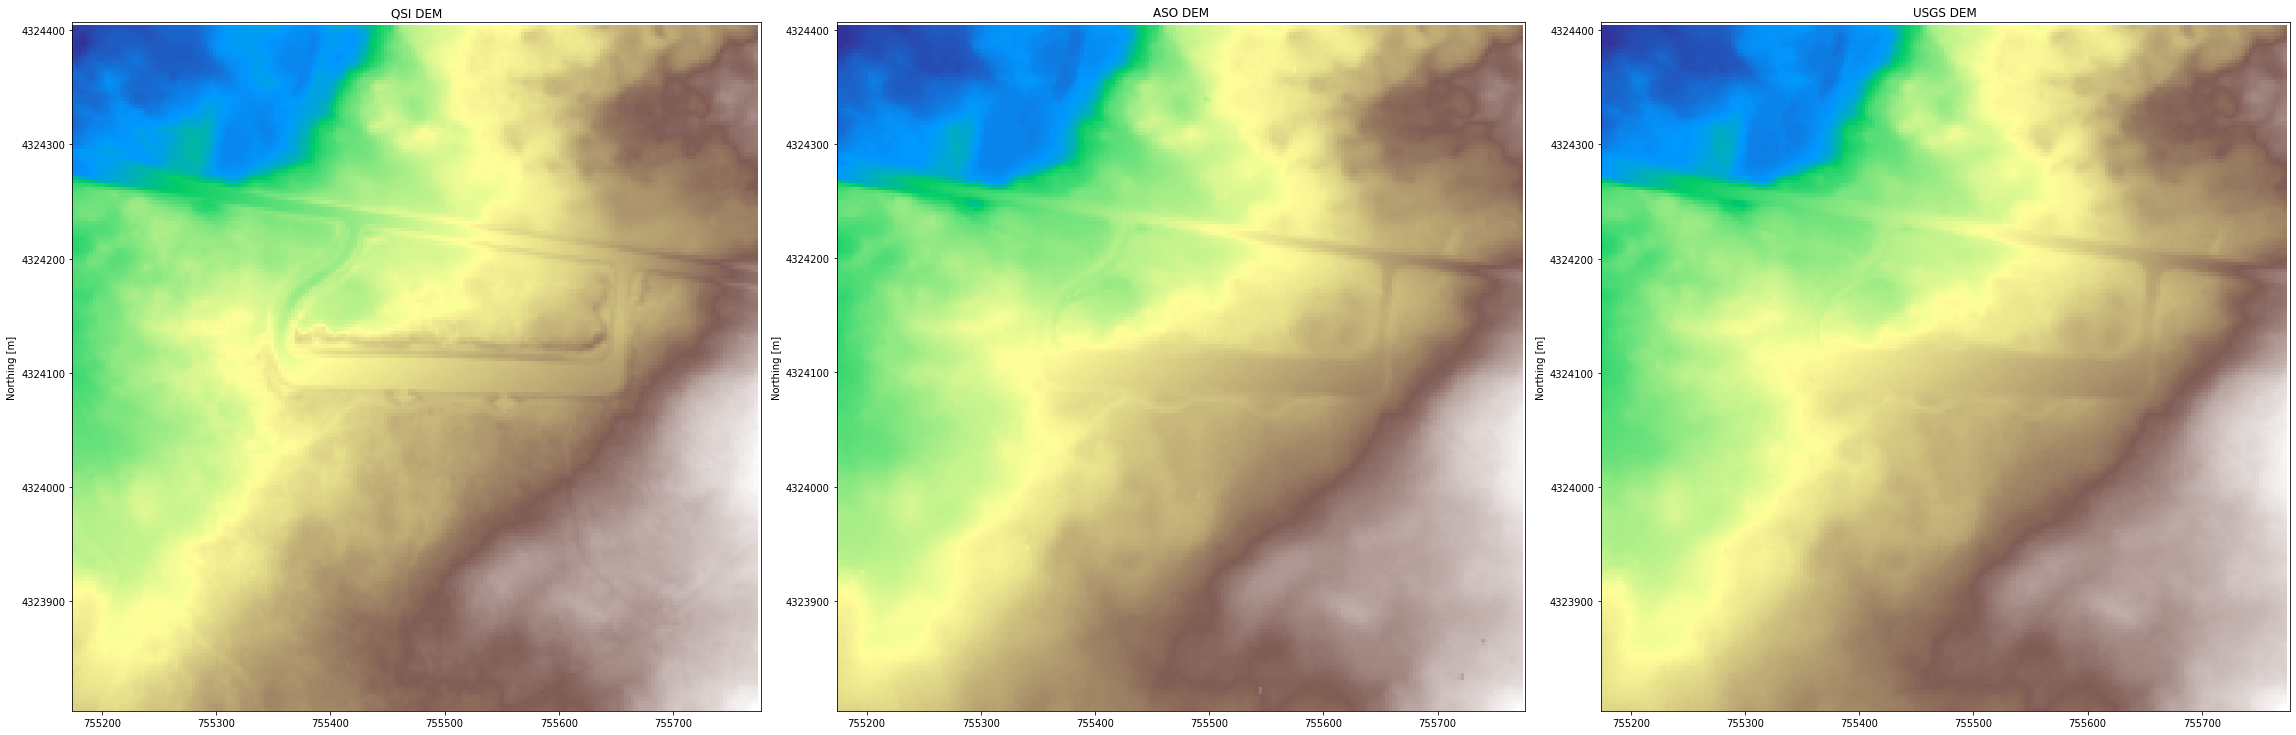

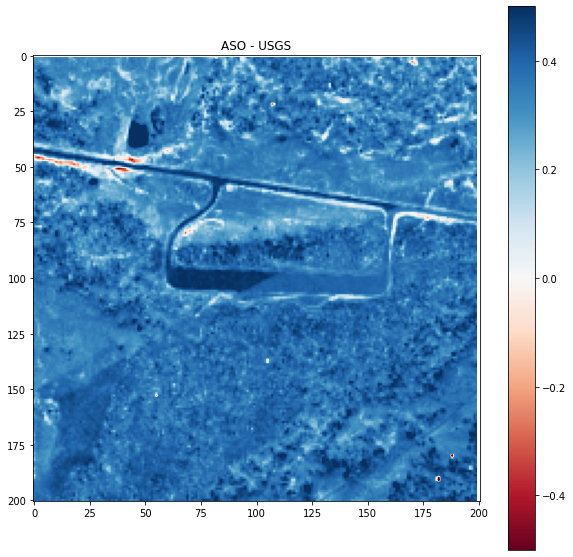

In [5]:
# Plot these to confirm we have something similar
fig, axes = plt.subplots(1,len(imgs.keys()), figsize=(32, 16))
i = 0 

for dem in imgs.keys():
    ax = axes[i]
    cmap = 'terrain'
    dst = rio[dem]
    img = imgs[dem]
    
    # Plot the raster
    show(img, transform=dst.transform, cmap=cmap, ax=ax, interpolation=None)
    print(dem.upper())
    print_stats(img)
    # Plot the pit location on top of each snow off raster
    #buffered_pit_df.iloc[1:].plot(ax=ax, marker='^', color='magenta',  markersize=150, edgecolor='black')
    
    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_ylabel('Northing [m]')
    ax.set_title('{} DEM'.format(dem.upper()))
    
    # Iterate the index for the subplot number
    i += 1
    
plt.tight_layout()
diff = imgs['ASO'] - imgs['USGS']

fig, ax = plt.subplots(1,1, figsize=(10, 10))
im = ax.imshow(diff, cmap='RdBu', vmin=-0.5, vmax=0.5)
ax.set_title('ASO - USGS')
plt.colorbar(im)
plt.savefig('/home/micah/Pictures/SnowOffDEM.png')        

print('Difference:')
print_stats(diff)

### Step 5. Create the snow depth maps

In [6]:
# Calculate the snow depth maps
usgs_depths = imgs['QSI'] - imgs['USGS']
aso_depths = imgs['QSI'] - imgs['ASO']

# Calculate a difference map
diff = aso_depths - usgs_depths

### Step 6. Plot snow depths

ASO
	mean = 0.5044542551040649
	min = -1.0673828125
	max = 2.608642578125
	std = 0.2825620472431183
USGS
	mean = 0.8587068319320679
	min = -0.061767578125
	max = 2.91162109375
	std = 0.2587217390537262
DIFF
	mean = -0.3542526662349701
	min = -1.630126953125
	max = 0.8564453125
	std = 0.07815644145011902


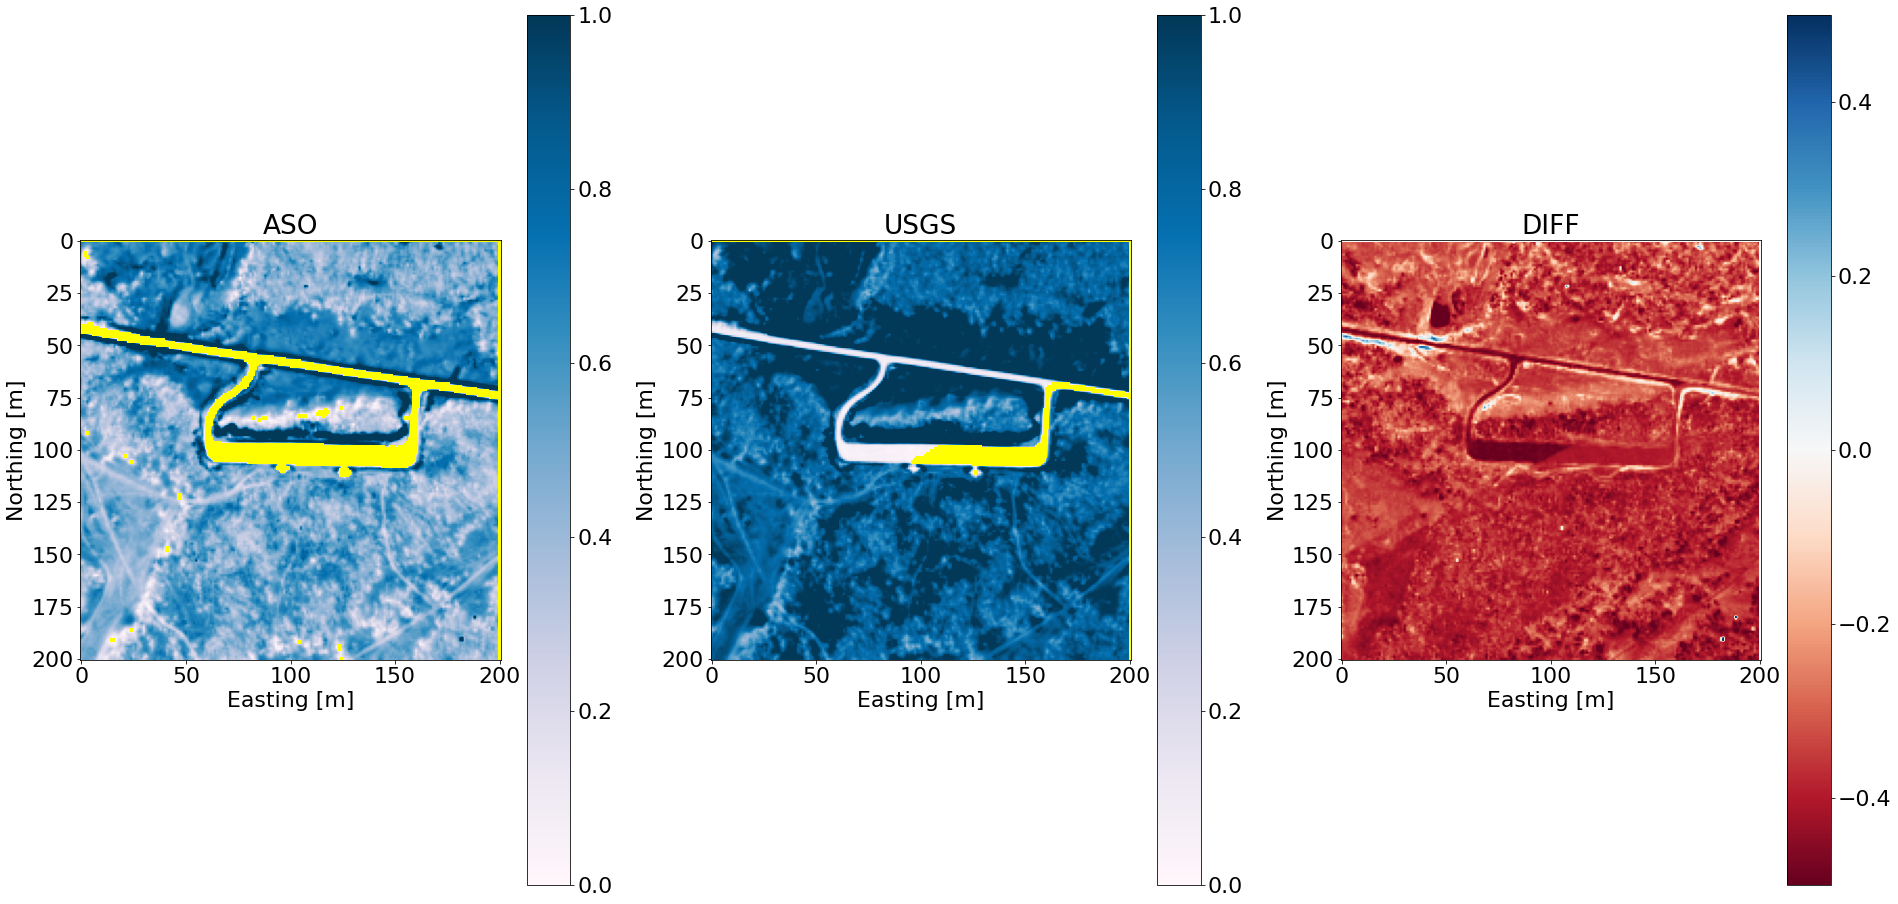

In [7]:
# Create a single plot to add everything to
data = {'aso':aso_depths, 'usgs': usgs_depths, 'diff':diff}

# Make the number of subplots the same as the dictionary of data
nplots = len(data.keys())
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1, nplots, figsize=(32, 16))

# plot indexer
i = 0 

# Plot the Snow Depths
for name, img in data.items():
    # Perform some Stats
    print(name.upper())
    print_stats(img)
    
    if name == 'diff':
        cmap = 'RdBu'
        title = 'Diff (ASO - USGS)'
        vmin = -0.5
        vmax = 0.5
        cm = plt.get_cmap(cmap)

    else:
        cmap = 'PuBu'
        vmin = 0
        vmax = 1
        img = np.ma.masked_where(img < 0, img)
        cm = plt.get_cmap(cmap)
        cm.set_bad(color='yellow')
    # Grab the subplot object
    ax = axes[i]
    im = ax.imshow(img, cmap=cm, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)    
    
    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(name.upper())
    i += 1
plt.savefig('/home/micah/Pictures/SnowDepthCompare.png')        
# plt.tight_layout()


### Step 7: Compare to in-situ depths

Differences at a Point:
ASO:


AttributeError: 'int' object has no attribute 'dtype'

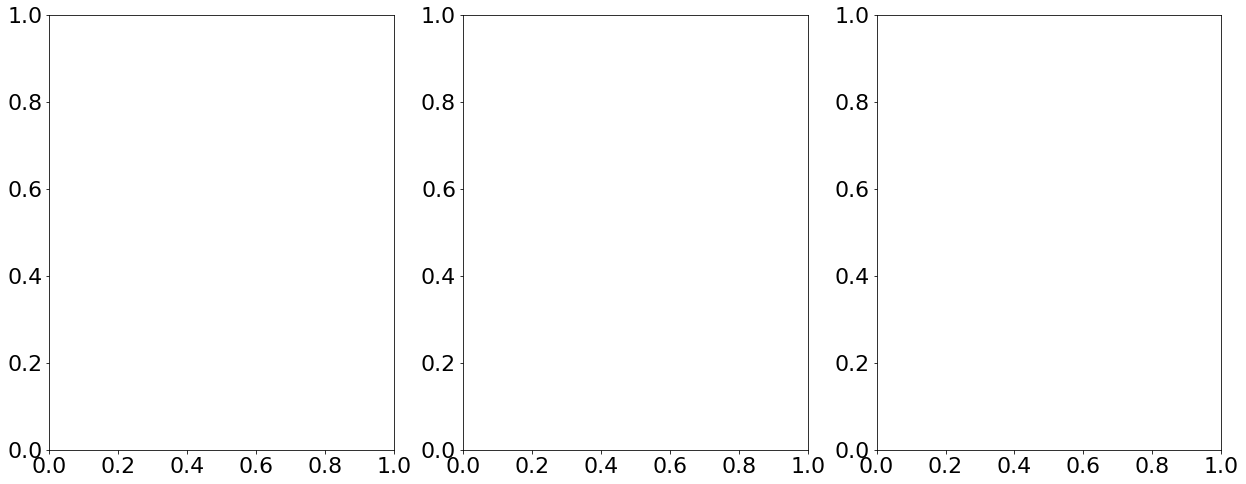

In [8]:
# query the db to grab all measured snow depths from the buffered pit and day of the over flight
q = session.query(PointData).filter(PointData.type == 'depth')
q = q.filter(func.ST_Within(PointData.geom, buffered_pit))
q = q.filter(PointData.date == dt)
df = query_to_geopandas(q, engine)                  

# Build a dataframe for holding our comparisons to raster tiles
final = gpd.GeoDataFrame({'geom':[], 'ASO':[], 'USGS':[], 'MEASURED':[]})
final['MEASURED'] = df['value'].div(100)
final['geometry'] = df['geom'].copy()

# loop over every point found
for i,row in df.iterrows():
    x = row['easting']
    y = row['northing']
    
    # build iterators to grab the points from the rasters
    qsi_itr = rio['QSI'].sample([(x,y)])
    aso_itr = rio['ASO'].sample([(x,y)])
    usgs_itr = rio['USGS'].sample([(x,y)])
    
    # Loop over the pixels that rasterio found (should only be one each)
    for q,a,u in zip(qsi_itr, aso_itr, usgs_itr):
        aso_d = q - a
        usgs_d = q - u
        
    # Add these depths to our dataframe
    final['ASO'].iloc[i] = aso_d
    final['USGS'].iloc[i] = usgs_d

dnames = ['ASO','USGS']
names = ['MEASURED'] + dnames
extent = [df['easting'].min(), df['northing'].min(), df['easting'].max(), df['northing'].max()]

# Make a plot
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

# Calculate the differences print out some stats on it
print("Differences at a Point:")
for i, dem in enumerate(dnames):
    diff_name = '{}_DIFF'.format(dem)
    final[diff_name] = final[dem] - final['MEASURED']
    print('{}:'.format(dem))
    print_stats(final[diff_name])

    # 1 and 2. Plot the snow depth map with the points overlaid colored by the differences we calculated
    ax = axes[i]
    
    # Show the snow depth raster
    show(aso_depths, transform=rio[dem].transform, cmap='PuBu', ax=ax, extent=extent)
    
    # Plot the points
    final.plot(ax=ax, column=diff_name, legend=True, vmin=-0.5, vmax=0.5, cmap='RdBu')
    
    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(diff_name.upper().replace('_', ' ') + '\n(Raster - Meas.)')
        
# 3. Plot the scatter plot showing raster depths compared to measured depths
ax = axes[2]
ax.plot(final['MEASURED'].values, final['ASO'].values, 'c.', label='ASO')
ax.plot(final['MEASURED'].values, final['USGS'].values, 'm.', label='USGS')
ax.plot([0, 1.5],[0, 1.5], 'k-.',label='1-1')

?

# Don't use scientific notation on the axis ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Add x/y labels, a title, a legend and avoid overlapping labels
ax.set_xlabel('Manual Measured Snow Depth [m]')
ax.set_ylabel('Raster Snow Depth [m]')
ax.set_title('Raster vs Manual Snow Depths')
ax.legend()

# Make the limits the same for both axies to show 1-1 better
lims = (0.9 * final[names].min().min(), 1.1 * final[names].max().max())
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.tight_layout()
plt.savefig('/home/micah/Pictures/pixel_vs_points_depth.png')


In [ ]:
# Close out the database transaction to avoid hanging transactions
# session.close()
